# Environment

In [1]:
!nvidia-smi

Mon Dec  9 00:03:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A10G                    On  | 00000000:00:1E.0 Off |                    0 |
|  0%   24C    P8              15W / 300W |      2MiB / 23028MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Experiments

In [2]:
from utils import launch_job, plot_train_loss_f1, metric_table, gen_top_n_mistakes
from IPython.display import display, HTML

In [3]:
dataset = "finerord"
base_model_config = {
    "dataset": dataset,
    "embedding": "fasttext",
    "model": "lstm",
    "lr": 0.01,
    "n_head": -1,
    "n_layer": -1
}

## Baseline: LSTM with Fasttext

In [4]:
embedding = "fasttext"
model = "lstm"
model_name = "LSTM"
lstm_config = base_model_config.copy()
lstm_config["embedding"] = embedding
lstm_config["model"] = model
lstm_config["lr"] = 0.01
model_dir = launch_job(**lstm_config)

------------------------------------------------------------------------------------------------------------------------
python train.py --data_dir /home/omniai-jupyter/nlp/data/finerord --model_dir /home/omniai-jupyter/nlp/pyanalysis/data_backup/train/finerord/fasttext_lstm_0.01 --embedding fasttext --model lstm --learning_rate 0.01
100%|██████████| 181/181 [00:00<00:00, 248.28it/s, loss=0.015]
evaluate.py --data_dir /home/omniai-jupyter/nlp/data/finerord --model_dir /home/omniai-jupyter/nlp/pyanalysis/data_backup/train/finerord/fasttext_lstm_0.01 --embedding fasttext --model lstm --learning_rate 0.01
- Test Eval complete ; process_time: 0.6988112460021512 ; loss: 0.09318767565127928 ; accuracy: 0.9730943914508661 ; entity_classification: {'overall_f1': 0.7222222222222221, 'overall': [[130.0, 35.0, 65.0, 195.0, 0.7878787878787878, 0.6666666666666666, 0.7222222222222221], [52.0, 16.0, 50.0, 102.0, 0.7647058823529411, 0.5098039215686274, 0.6117647058823529], [37.0, 5.0, 7.0, 44.0, 0.880

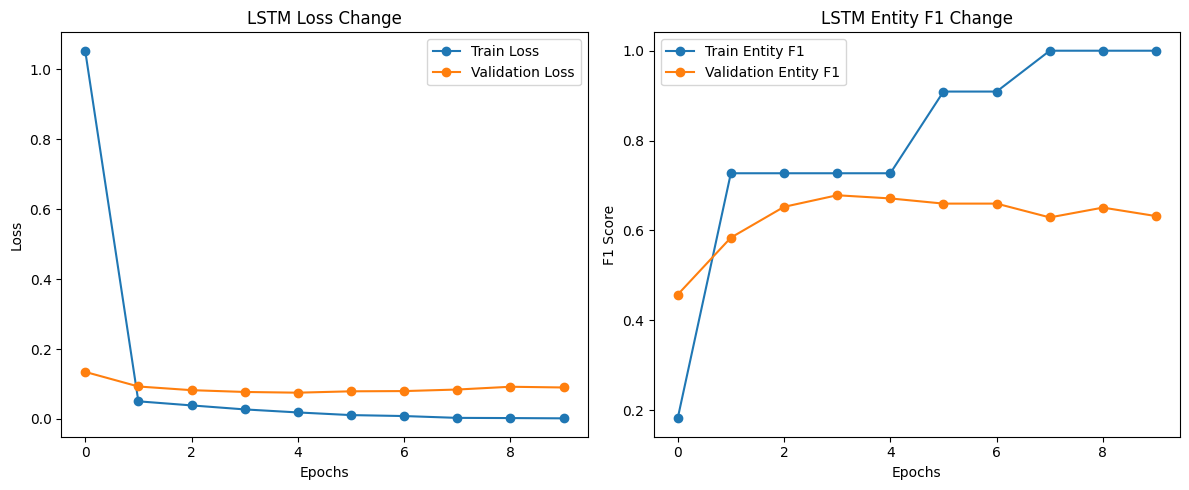

In [5]:
plot_train_loss_f1(model_dir=model_dir, model_name=model_name)

In [6]:
metric_df = metric_table(model_dir=model_dir, model_name=model_name)
display(metric_df) 

,Model,Tag,TP,FP,FN,Support,Precision,Recall,F1
0,LSTM,ALL,130.0,35.0,65.0,195.0,0.787879,0.666667,0.722222
1,LSTM,ORG,52.0,16.0,50.0,102.0,0.764706,0.509804,0.611765
2,LSTM,PER,37.0,5.0,7.0,44.0,0.880952,0.840909,0.860465
3,LSTM,LOC,41.0,14.0,8.0,49.0,0.745455,0.836735,0.788462


In [7]:
mistakes = gen_top_n_mistakes(model_dir=model_dir, model_name=model_name)
# mistakes = gen_top_n_mistakes(model_dir=model_dir, model_name=model_name, tag="LOC", metric="Recall", top_n=10)
display(HTML(mistakes))

As you can see, the F1 score is not satisfactory, especially for ORG.

## Fine-tuned Transformers

In [8]:
embedding = "uncased"
model = "bert"
model_name = "BERT"
bert_config = base_model_config.copy()
bert_config["embedding"] = embedding
bert_config["model"] = model
bert_config["lr"] = 0.00005
model_dir = launch_job(**bert_config)

------------------------------------------------------------------------------------------------------------------------
python train.py --data_dir /home/omniai-jupyter/nlp/data/finerord --model_dir /home/omniai-jupyter/nlp/pyanalysis/data_backup/train/finerord/uncased_bert_5e-05 --embedding uncased --model bert --learning_rate 5e-05
Some weights of BertForTokenClassification were not initialized from the model checkpoint at /home/omniai-jupyter/nlp/pyanalysis/model/nlp/bert-base-uncased/torch and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 181/181 [00:10<00:00, 16.56it/s, loss=0.005]
evaluate.py --data_dir /home/omniai-jupyter/nlp/data/finerord --model_dir /home/omniai-jupyter/nlp/pyanalysis/data_backup/train/finerord/uncased_bert_5e-05 --embedding uncased --model bert --learning_rate 5e-05
Some weights of BertForTokenClassification were n

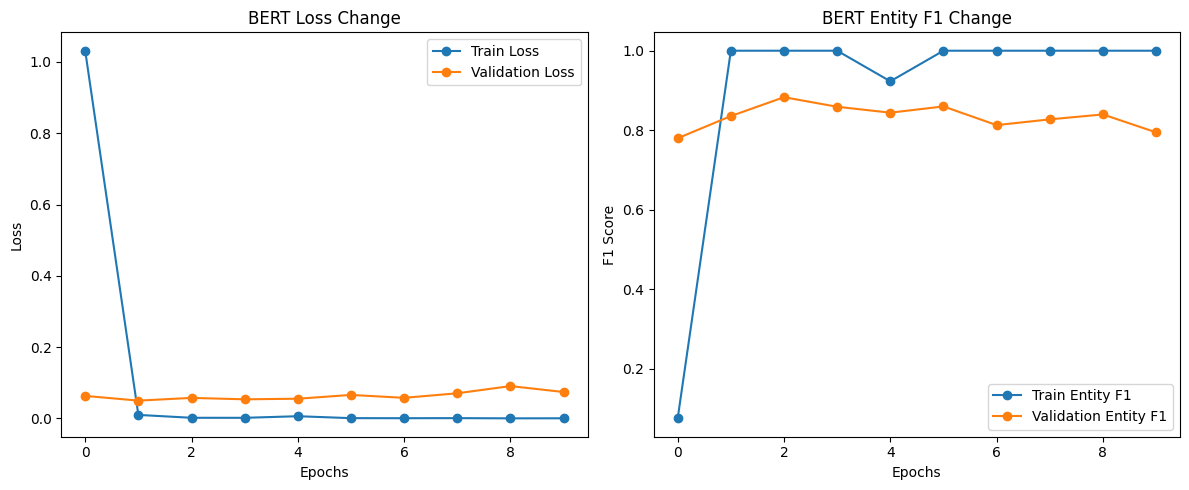

In [9]:
plot_train_loss_f1(model_dir=model_dir, model_name=model_name)

In [10]:
metric_df = metric_table(model_dir=model_dir, model_name=model_name)
display(metric_df)

,Model,Tag,TP,FP,FN,Support,Precision,Recall,F1
0,BERT,ALL,167.0,45.0,28.0,195.0,0.787736,0.856410,0.820639
1,BERT,ORG,81.0,31.0,21.0,102.0,0.723214,0.794118,0.757009
2,BERT,PER,43.0,3.0,1.0,44.0,0.934783,0.977273,0.955556
3,BERT,LOC,43.0,11.0,6.0,49.0,0.796296,0.877551,0.834951


Woo! It improves a lot. ORG is still the hardest.

In [11]:
mistakes = gen_top_n_mistakes(model_dir=model_dir, model_name=model_name)
# mistakes = gen_top_n_mistakes(model_dir=model_dir, model_name=model_name, tag="LOC", metric="Recall", top_n=10)
display(HTML(mistakes))

## Transfer Learning

We first need to create a fine-tuned model fed with enough dataset. Conll 2003 is a good choice. Notice, as our target dataset has only ORG/PER/LOC tags, I have manully convert MISC to O beforehand.

In [14]:
embedding = "uncased"
model = "bert"
model_name = "BERT"
conll_config = base_model_config.copy()
conll_config["dataset"] = "conll2003"  # pre-train the model with CONLL 2003 Dataset
conll_config["embedding"] = embedding
conll_config["model"] = model
conll_config["lr"] = 0.00005
model_dir = launch_job(**conll_config)

------------------------------------------------------------------------------------------------------------------------
python train.py --data_dir /home/omniai-jupyter/nlp/data/conll2003 --model_dir /home/omniai-jupyter/nlp/pyanalysis/data_backup/train/conll2003/uncased_bert_5e-05 --embedding uncased --model bert --learning_rate 5e-05
Some weights of BertForTokenClassification were not initialized from the model checkpoint at /home/omniai-jupyter/nlp/pyanalysis/model/nlp/bert-base-uncased/torch and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 3067/3067 [02:54<00:00, 17.63it/s, loss=0.010]
evaluate.py --data_dir /home/omniai-jupyter/nlp/data/conll2003 --model_dir /home/omniai-jupyter/nlp/pyanalysis/data_backup/train/conll2003/uncased_bert_5e-05 --embedding uncased --model bert --learning_rate 5e-05
Some weights of BertForTokenClassification 

The overall F1 is high after being trained by 14041 setences. For transfer learning, we will initially load pre-trained CONLL 2003 model before training FiNER-ORD. This time, I need to update the params.json.

In [44]:
from utils import Params
cur_params = Params("params.json")
cur_params.pre_trained_tar = "/home/omniai-jupyter/nlp/pyanalysis/data_backup/train/conll2003/uncased_bert_5e-05/best.pth.tar"  # pre-trained CONLL 2003
cur_params.save("params.json")

In [46]:
embedding = "uncased"
model = "bert"
model_name = "BERT"
transfer_config = base_model_config.copy()
transfer_config["dataset"] = dataset  # FiNER-ORD training based on CONL L2003
transfer_config["embedding"] = embedding
transfer_config["model"] = model
transfer_config["lr"] = 0.00005
model_dir = launch_job(**transfer_config)

------------------------------------------------------------------------------------------------------------------------
python train.py --data_dir /home/omniai-jupyter/nlp/data/finerord --model_dir /home/omniai-jupyter/nlp/pyanalysis/data_backup/transfer/finerord/uncased_bert_5e-05 --embedding uncased --model bert --learning_rate 5e-05
Some weights of BertForTokenClassification were not initialized from the model checkpoint at /home/omniai-jupyter/nlp/pyanalysis/model/nlp/bert-base-uncased/torch and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 181/181 [00:10<00:00, 16.53it/s, loss=0.003]
evaluate.py --data_dir /home/omniai-jupyter/nlp/data/finerord --model_dir /home/omniai-jupyter/nlp/pyanalysis/data_backup/transfer/finerord/uncased_bert_5e-05 --embedding uncased --model bert --learning_rate 5e-05
Some weights of BertForTokenClassification 

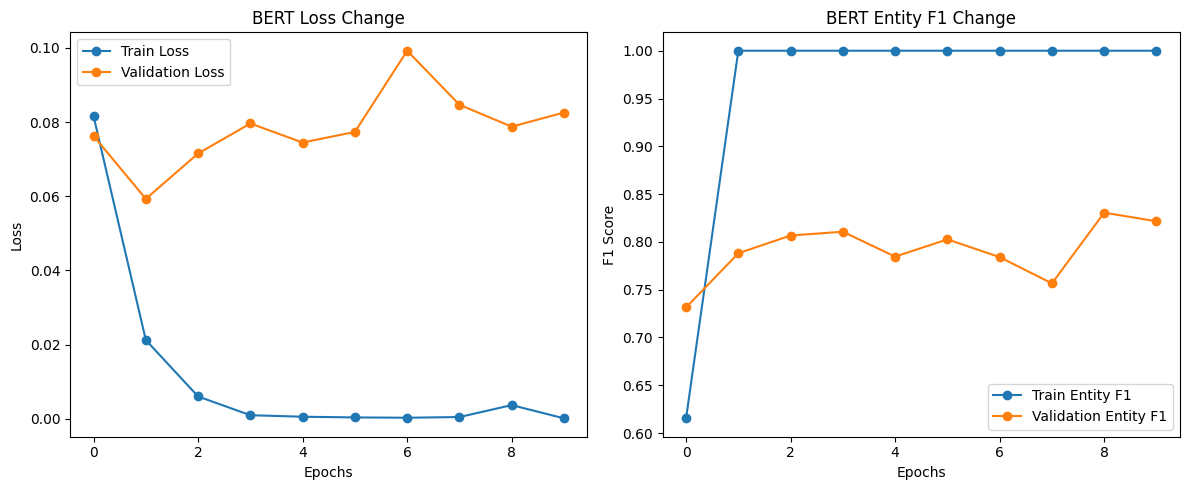

In [50]:
plot_train_loss_f1(model_dir=model_dir, model_name=model_name)mo

In [52]:
metric_df = metric_table(model_dir=model_dir, model_name=model_name)
display(metric_df)

,Model,Tag,TP,FP,FN,Support,Precision,Recall,F1
0,BERT,ALL,173.0,33.0,22.0,195.0,0.839806,0.887179,0.862843
1,BERT,ORG,84.0,23.0,18.0,102.0,0.785047,0.823529,0.803828
2,BERT,PER,43.0,2.0,1.0,44.0,0.955556,0.977273,0.966292
3,BERT,LOC,46.0,8.0,3.0,49.0,0.851852,0.938776,0.893204


Transfer learning works. The metrics can now beat even the GPT 4.

In [54]:
mistakes = gen_top_n_mistakes(model_dir=model_dir, model_name=model_name)
# mistakes = gen_top_n_mistakes(model_dir=model_dir, model_name=model_name, tag="LOC", metric="Recall", top_n=10)
display(HTML(mistakes))

Even though ORG is till the hardest, the misclassification can be more easily made by human.

In [57]:
mistakes = gen_top_n_mistakes(model_dir=model_dir, model_name=model_name, tag="PER", metric="Recall", top_n=10)
display(HTML(mistakes))

The NER for PER is amazing. Only 1 PER was missed. 1 email address was misclassified as PER. The other one is even confusing to me. Good job, transfer learning. Hooray! 